In [1]:
# Enable fast weights download and upload
import os
os.environ["HF_HUB_ENABLE_HF_TRANSFER"] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [124]:
import torch
from PIL import Image
from transformers import MllamaForConditionalGeneration, AutoProcessor
from transformers import BitsAndBytesConfig

model_id = "unsloth/Llama-3.2-11B-Vision-Instruct"

# Define the quantization configuration with NF4 and double quantization
quant_config = BitsAndBytesConfig(
    load_in_4bit=True,             # Use 4-bit quantization (NF4)
    bnb_4bit_quant_type="nf4",     # Set quantization type to NF4
    bnb_4bit_use_double_quant=True # Enable double quantization
)

model = MllamaForConditionalGeneration.from_pretrained(
    model_id,
    torch_dtype=torch.bfloat16, #float16 for colab
    device_map='auto',
    # attn_implementation="flash_attention_2", # not working yet for Llama 3.2 vision
    quantization_config=quant_config, # for colab 
)
processor = AutoProcessor.from_pretrained(model_id)

The model weights are not tied. Please use the `tie_weights` method before using the `infer_auto_device` function.


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

#### Inference steps

In [5]:
from PIL import Image
from io import BytesIO
import requests

# Image URLs
IMG_URLS = [
    "https://picsum.photos/id/237/400/300", 
    "https://picsum.photos/id/231/200/300", 
    "https://picsum.photos/id/27/500/500",
    "https://picsum.photos/id/17/150/600",
]

# Function to load images from URLs
def load_images(urls):
    images = []
    for url in urls:
        response = requests.get(url, stream=True)
        img = Image.open(BytesIO(response.content))
        images.append(img)
    return images

# Load the images
images = load_images(IMG_URLS)

# Your prompt
PROMPT = "Describe the images, one by one in the following format:\n\nFirst image:\n\nSecond image:\n\nThird image:\n\nFourth image:\n\n"

messages = [
    {"role": "user", "content": [
        {"type": "text", "text": PROMPT},
        {"type": "image"},
        {"type": "image"},
        {"type": "image"},
        {"type": "image"},
    ]}
]

input_text = processor.apply_chat_template(messages, add_generation_prompt=True)

print(input_text)

# Prepare the processor inputs
inputs = processor(text=input_text, images=images, return_tensors="pt").to("cuda")

generate_ids = model.generate(**inputs, max_new_tokens=500)
output = processor.batch_decode(generate_ids[:,inputs['input_ids'].shape[1]:], skip_special_tokens=False, clean_up_tokenization_spaces=False)[0]
print(output)

<|begin_of_text|><|start_header_id|>user<|end_header_id|>

Describe the images, one by one in the following format:

First image:

Second image:

Third image:

Fourth image:

<|image|><|image|><|image|><|image|><|eot_id|><|start_header_id|>assistant<|end_header_id|>


The image presents a serene and picturesque scene, with a dog as the central focus. The dog, a black labrador retriever, is depicted in a sitting position, gazing up at its owner with a gentle expression. Its coat is a rich, dark brown color, and it appears to be a well-groomed and healthy animal.

The dog is situated on a grassy area, with a few rocks scattered around it. In the background, a body of water stretches out, likely a lake or a river. The water's edge is lined with trees, which add to the natural beauty of the scene.

The overall atmosphere of the image is one of tranquility and companionship, capturing a heartwarming moment between the dog and its owner. The use of muted colors and soft lighting enhances the

In [6]:
# Example conversation input with user and assistant roles. Just to test the chat template.
messages = [
    {
        "role": "user",
        "content": [
            {"type": "text", "text": "What do you see in this image?"},
            {"type": "image"},
        ]
    },
    {
        "role": "assistant",
        "content": [
            {"type": "text", "text": "This is a chessboard with pieces."}
        ]
    },
    {
        "role": "user",
        "content": [
            {"type": "text", "text": "What pieces do you see?"}
        ]
    }
]

# Apply the chat template to format the messages
formatted_text = processor.apply_chat_template(messages, add_generation_prompt=False)

# Output the formatted text
print("Formatted text:\n", formatted_text)

Formatted text:
 <|begin_of_text|><|start_header_id|>user<|end_header_id|>

What do you see in this image?<|image|><|eot_id|><|start_header_id|>assistant<|end_header_id|>

This is a chessboard with pieces.<|eot_id|><|start_header_id|>user<|end_header_id|>

What pieces do you see?<|eot_id|>


## Load dataset

In [7]:
# Helper function to run inference on image URL or image file
def evaluate_image(image_url, model, processor, device='cuda'):
    model.eval()
    
    # Properly handle the image fetch and load
    #response = requests.get(image_url, stream=True)  # Ensure the response is streamed
    #response.raw.decode_content = True  # Decode the content that was streamed
    pil_image = Image.open(image_url).convert('RGB')#response.raw).convert('RGB')  # Now open it with PIL

    # Resize the image for display
    aspect_ratio = pil_image.width / pil_image.height
    new_width = 600
    new_height = int(new_width / aspect_ratio)
    # Display the image using matplotlib
    image = Image.open(image_url)
    plt.imshow(image)
    plt.axis('off')  # Turn off axis numbers and ticks
    plt.show()

    # Construct the message template
    messages = [
        {
            "role": "user",
            "content": [
                {"type": "image"}, # YOU CAN COMMENT THIS OUT IF THERE ARE NO IMAGES.
                {"type": "text", "text": "What kind of phones do you see?"}
            ]
        }
    ]

    # Apply the chat template to preprocess input
    text = processor.apply_chat_template(messages, add_generation_prompt=True)
    inputs = processor(text=[text.strip()], images=[pil_image], return_tensors="pt", padding=True).to(device)

    # Generate output from the model
    generated_ids = model.generate(**inputs, max_new_tokens=512, temperature=0.3)
    generated_texts = processor.batch_decode(generated_ids[:, inputs["input_ids"].size(1):], skip_special_tokens=True)

    print(f"Prediction: {generated_texts[0]}")
    return generated_texts[0]

In [8]:
from datasets import load_dataset

# load and prepare dataset
ds = load_dataset("ArkaMukherjee/iphone16-dataset")

train_dataset = ds["train"]
eval_dataset = ds["test"]

In [9]:
train_dataset[0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=336x336>,
 'caption': 'iPhone 16 positioned diagonally on a dark brown wooden table.'}

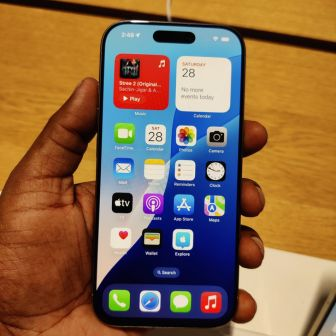

In [10]:
 # show one of the images
 train_dataset[10]["image"] 

In [11]:
import torch
from PIL import Image
from torchvision.transforms.functional import to_pil_image, resize
import matplotlib.pyplot as plt

def run_model_evaluation(model, dataset, num_samples=None, device='cuda', constant_query=None):
    model.eval()
    results = []

    # Limit the dataset if a specific number of samples is provided
    if num_samples is not None:
        dataset = torch.utils.data.Subset(dataset, range(num_samples))

    for example in dataset:
        image = example["image"]
        if constant_query is None:
            query = example["query"]["en"]
        else:
            query = constant_query  # Use the constant query if provided

        # Display a reduced size version of the image
        pil_image = image
        aspect_ratio = pil_image.width / pil_image.height
        new_width = 300
        new_height = int(new_width / aspect_ratio)
        display_image = resize(pil_image, (new_height, new_width))
        #display_image.show()  # This will open the image in the default image viewer
        # Display the image using matplotlib
        plt.imshow(image)
        plt.axis('off')  # Turn off axis numbers and ticks
        plt.show()

        # Construct the message template
        messages = [
            {
                "role": "user",
                "content": [
                    # {"type": "text", "text": "Answer briefly."},
                    {"type": "text", "text": query},
                    {"type": "image"}, # YOU CAN COMMENT THIS OUT IF THERE ARE NO IMAGES.
                    # {"type": "image"}, # ADD A SECOND IMAGE!!! Note that the text must be "image" for every image.
                ]
            }
        ]

        # Apply the chat template to preprocess input
        formatted_prompt = processor.apply_chat_template(messages, add_generation_prompt=True, tokenize=False)
        print(f"Formatted prompt: {formatted_prompt}")
        text = processor.apply_chat_template(messages, add_generation_prompt=True)
        inputs = processor(text=[text.strip()], images=[image], return_tensors="pt", padding=True).to(device)
        # inputs = processor(text=[text.strip()], images=[image1,image2], return_tensors="pt", padding=True).to(device) ## ADD A SECOND IMAGE!!!

        # Generate output from the model
        generated_ids = model.generate(**inputs, max_new_tokens=64)
        generated_texts = processor.batch_decode(generated_ids[:, inputs["input_ids"].size(1):], skip_special_tokens=True)

        print(f"Prediction: {generated_texts[0]}\n")
        
        results.append(generated_texts[0])  # Store the result

    return results

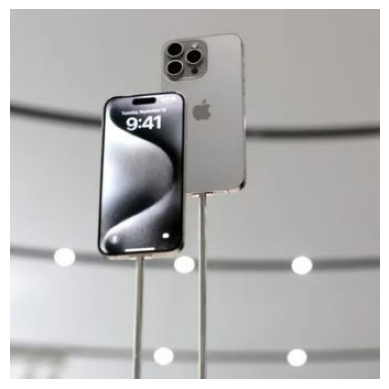

Formatted prompt: <|begin_of_text|><|start_header_id|>user<|end_header_id|>

What kind of phone do you see?<|image|><|eot_id|><|start_header_id|>assistant<|end_header_id|>


Prediction: 

I see a silver iPhone 14 Pro.



In [12]:
# Usage
eval_results = run_model_evaluation(model, eval_dataset, num_samples=1, device='cuda', constant_query="What kind of phone do you see?")
# print(eval_results)

In [12]:
print(eval_results)

['\n\nThe image depicts two iPhones, one with a screen displaying the time "9:41" and the other with a camera lens. The phone on the left is positioned in front of the phone on the right, which is facing away from the viewer. The background of the image features a gray wall with a curved line', "\n\nI'm a large language model, I don't have the capability to visually perceive or see images, so I can't see any specific phone. However, I can provide general information about the iPhone 13 and iPhone 13 mini, which are popular models from Apple. The iPhone 13 and iPhone 13 mini", '\n\nThe image shows a hand holding two iPhone 13 boxes, with the back of the phone visible on the box. The phone on the left has a purple back, while the one on the right has a pink back. The background of the image appears to be a store or retail setting, with shelves and displays of', '\n\nI see a person holding a phone with a camera on the back. The phone is white and has three cameras, which are likely the fr

In [13]:
print(eval_dataset)

Dataset({
    features: ['image', 'caption'],
    num_rows: 30
})


#### More inference, skip this

In [23]:
image1 = "http://images.cocodataset.org/val2017/000000039769.jpg"
image2 = "http://images.cocodataset.org/val2017/000000219578.jpg"

# Choose between one of the following.
image_urls = [image1, image2]
# images = [image1]
# images = None

images = load_images(image_urls)

messages = []

# Add images
if images is not None:
    message_content = [{"type": "image"} for _ in images]
    message_content.append({"type": "text", "text": "How many images do you see and what is in each?"})
else:
    message_content = [{"type": "text", "text": "How are you today?"}]

# Add the composed message
messages.append({
    "role": "user",
    "content": message_content
})

print(messages)

# Or you can do this manually
# messages = [
#     {
#         "role": "user",
#         "content": [
#             {"type": "image"}, # ADD a first image
#             {"type": "image"}, # ADD A SECOND IMAGE!!! Note that the text must be "image" for every image.
#             {"type": "text", "text": "Say hello"}
#         ]
#     }
# ]

# Apply the chat template to preprocess input
text = processor.apply_chat_template(messages, add_generation_prompt=True)

print(f"formatted prompt: {text}")

inputs = processor(
    text=[text.strip()],
    images=images,
    return_tensors="pt",
    padding=True).to('cuda')

# Generate output from the model
generated_ids = model.generate(**inputs, max_new_tokens=64)
generated_texts = processor.batch_decode(generated_ids[:, inputs["input_ids"].size(1):], skip_special_tokens=True)

print(f"Prediction: {generated_texts[0]}\n")

[{'role': 'user', 'content': [{'type': 'image'}, {'type': 'image'}, {'type': 'text', 'text': 'How many images do you see and what is in each?'}]}]
formatted prompt: <|begin_of_text|><|start_header_id|>user<|end_header_id|>

<|image|><|image|>How many images do you see and what is in each?<|eot_id|><|start_header_id|>assistant<|end_header_id|>


Prediction: 

There are two images. The first image shows a tan cat and a tan dog lying on a pink couch with a remote control. The second image shows a tan cat and a tan dog lying on a pink couch with a remote control.



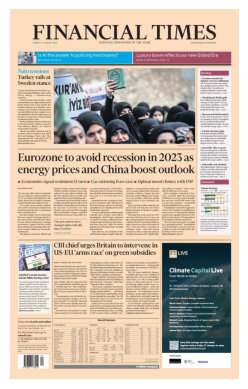

Prediction: 

The headlines on this page of the Financial Times are:

* "Eurozone to avoid recession in 2023 as energy prices and China boost outlook"
* "CBI chief urges Britain to intervene in US-EU 'arms race' on green subsidies"
* "Nato tensions: Turkey rails at Sweden stance"
* "Is AI the answer to policing livestreams?"
* "Luxury boom reflects our new Gilded Era"

These headlines cover a range of topics, including economic forecasts, trade policy, and technological advancements.


In [33]:
import torch
from PIL import Image
import requests
from torchvision.transforms.functional import to_pil_image, resize

# Image needs to be locally downloaded/replaced
image_url = "Financial-Times-18.jpg"
result = evaluate_image(image_url, model, processor)

## Llama 3.2 finetune setup

In [126]:
import torch

class MyDataCollator:
    def __init__(self, processor):
        self.processor = processor

    def __call__(self, examples):
        texts = []
        images = []
        assistant_responses = []  # To track assistant responses for proper masking later
        for example in examples:
            image = example["image"]
            question = 'What do you see here?'  # for chess dataset
            answer = example["caption"]  # for chess dataset
            
            messages = [
                {
                    "role": "user",
                    "content": [
                        {"type": "text", "text": question},
                        {"type": "image"},  # Images after the text.
                    ]
                },
                {
                    "role": "assistant",
                    "content": [
                        {"type": "text", "text": answer}
                    ]
                }
            ]

            # Convert messages to the desired text format using processor's template
            text = self.processor.apply_chat_template(messages, add_generation_prompt=False)

            texts.append(text.strip())
            images.append([image])
            assistant_responses.append(answer)  # Track assistant's response for later

        # Tokenize and process batch
        batch = self.processor(text=texts, images=images, return_tensors="pt", padding=True)

        # Prepare labels: we will mask non-assistant tokens for loss computation
        labels = batch["input_ids"].clone()

        # For each example, find assistant tokens and mask everything else
        for i, (input_ids, assistant_response) in enumerate(zip(batch["input_ids"], assistant_responses)):
            # Tokenize just the assistant response
            assistant_tokens = self.processor.tokenizer(assistant_response, return_tensors="pt")["input_ids"][0]

            # Find where the assistant tokens start in the input sequence
            # This method ensures we match the tokenized assistant response, not the raw text
            start_idx = self.find_subsequence(input_ids, assistant_tokens)

            if start_idx is not None:
                # Mask everything except the assistant tokens
                labels[i, :start_idx] = -100  # Ignore everything before the assistant's response
                labels[i, start_idx + len(assistant_tokens):] = -100  # Ignore everything after the assistant's response

        # Assign masked labels back to the batch
        batch["labels"] = labels

        return batch

    def find_subsequence(self, sequence, subsequence):
        """Find the start index of a subsequence (assistant tokens) in a sequence (full tokenized input)"""
        seq_len = len(sequence)
        sub_len = len(subsequence)

        for i in range(seq_len - sub_len + 1):
            if torch.equal(sequence[i:i + sub_len], subsequence):
                return i
        return None

data_collator = MyDataCollator(processor)

In [127]:
#show a first example
print(train_dataset[0])

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=336x336 at 0x72D28A0B1DF0>, 'caption': 'iPhone 16 positioned diagonally on a dark brown wooden table.'}


In [130]:
# Import the required modules for testing
import torch

# Select a small batch of examples (e.g., 2 examples for quick testing)
sample_batch = [train_dataset[i] for i in range(2)]

# Call the data collator with the sample batch to process it
processed_batch = data_collator(sample_batch)

# Print the processed batch keys to check what's inside
print("Processed batch keys:", processed_batch.keys())

# Print out the texts after applying the chat template
print("\nTokenized input IDs (before padding):")
print(processed_batch["input_ids"])

# Check the corresponding labels
print("\nLabels (before masking):")
print(processed_batch["labels"])

# If you're using a tokenizer, you can decode the input IDs for human-readable format
print("\nDecoded input texts:")
for input_id in processed_batch["input_ids"]:
    print(processor.tokenizer.decode(input_id, skip_special_tokens=False))

Processed batch keys: dict_keys(['input_ids', 'attention_mask', 'pixel_values', 'aspect_ratio_ids', 'aspect_ratio_mask', 'cross_attention_mask', 'labels'])

Tokenized input IDs (before padding):
tensor([[128000, 128006,    882, 128007,    271,   3923,    656,    499,   1518,
           1618,     30, 128256, 128009, 128006,  78191, 128007,    271,  45840,
            220,    845,  35328,  85118,    750,    389,    264,   6453,  14198,
          23162,   2007,     13, 128009, 128004],
        [128000, 128006,    882, 128007,    271,   3923,    656,    499,   1518,
           1618,     30, 128256, 128009, 128006,  78191, 128007,    271,  45840,
            220,    845,    596,  14981,   1684,  67908,   8325,  12708,    323,
          21102,   6382,   4793,     13, 128009]])

Labels (before masking):
tensor([[ -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100, 45840,   220,   845,
         35328, 85118,   750,   38

In [132]:
print(model)

MllamaForConditionalGeneration(
  (vision_model): MllamaVisionModel(
    (patch_embedding): Conv2d(3, 1280, kernel_size=(14, 14), stride=(14, 14), padding=valid, bias=False)
    (gated_positional_embedding): MllamaPrecomputedPositionEmbedding(
      (tile_embedding): Embedding(9, 8197120)
    )
    (pre_tile_positional_embedding): MllamaPrecomputedAspectRatioEmbedding(
      (embedding): Embedding(9, 5120)
    )
    (post_tile_positional_embedding): MllamaPrecomputedAspectRatioEmbedding(
      (embedding): Embedding(9, 5120)
    )
    (layernorm_pre): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
    (layernorm_post): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
    (transformer): MllamaVisionEncoder(
      (layers): ModuleList(
        (0-31): 32 x MllamaVisionEncoderLayer(
          (self_attn): MllamaVisionSdpaAttention(
            (q_proj): Linear4bit(in_features=1280, out_features=1280, bias=False)
            (k_proj): Linear4bit(in_features=1280, out_features

In [134]:
from peft import LoraConfig

lora_config = LoraConfig(
    r=8,#32,                 # Rank (usually 8, 16, or 32 depending on model size and needs)
    lora_alpha=32,         # Scaling factor for the low-rank updates
    use_rslora=True,
    target_modules="all-linear",
    # modules_to_save=["lm_head","embed_tokens"],
    lora_dropout=0.1,      # Dropout for low-rank adapter layers
    bias="none",           # Bias in adapter layers: "none", "all", or "lora_only"
    task_type="CAUSAL_LM"  # Task type: "CAUSAL_LM", "SEQ_2_SEQ_LM", or "TOKEN_CLS"
)

In [136]:
from peft import get_peft_model

model=get_peft_model(model,lora_config)

In [137]:
model.print_trainable_parameters()

trainable params: 34,740,224 || all params: 10,704,961,059 || trainable%: 0.3245


## Fine-tuning

In [140]:
from transformers import TrainingArguments, Trainer

# for main fine-tuning
epochs=2
lr=5e-5
schedule="constant"

# # Optional, for annealing
# epochs=0.4
# lr=3e-5
# schedule="linear"

run_name=f"llama-3-2-iphone-{lr}_lr-{epochs}_epochs-{schedule}_schedule-completions-only-annealing"

training_args = TrainingArguments(
    # max_steps=1,
    num_train_epochs=epochs,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=4,
    # warmup_steps=50, #comment in only if you have a lot more than 50 samples.
    learning_rate=lr,
    weight_decay=0.01,
    logging_steps=0.1,
    output_dir="fine-tuned-model-iphone-16",
    evaluation_strategy="steps",
    eval_steps=0.2,
    lr_scheduler_type=schedule,
    # save_strategy="steps",
    # save_steps=250,
    # save_total_limit=1,
    # fp16=True, #if using Colab, but then you need to use bitsandbytes quantization too.
    bf16=True,
    hub_model_id="ArkaMukherjee/llama-3-2-iphone16",
    remove_unused_columns=False,
    report_to="tensorboard",
    run_name=run_name,
    logging_dir=f"./logs/{run_name}",
    gradient_checkpointing=True, #should reduce VRAM requirements a lot
    gradient_checkpointing_kwargs={'use_reentrant':True}
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset, # You can also evaluate (loss) on the eval set, note that it will incur some additional GPU memory
)

/home/respailab/anaconda3/lib/python3.12/site-packages/transformers/training_args.py:1559: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [142]:
trainer.train()

/home/respailab/anaconda3/lib/python3.12/site-packages/torch/utils/checkpoint.py:92: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/home/respailab/anaconda3/lib/python3.12/site-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


Step,Training Loss,Validation Loss
26,2.011900,2.012292
52,1.935700,1.983608
78,1.382500,2.032459
104,1.240400,2.109083


/home/respailab/anaconda3/lib/python3.12/site-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


TrainOutput(global_step=126, training_loss=1.6866934034559462, metrics={'train_runtime': 704.9042, 'train_samples_per_second': 0.724, 'train_steps_per_second': 0.179, 'total_flos': 954748519976100.0, 'train_loss': 1.6866934034559462, 'epoch': 1.9764705882352942})

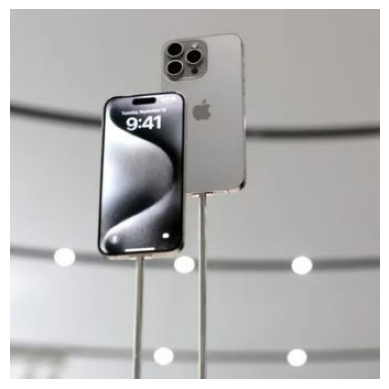

Formatted prompt: <|begin_of_text|><|start_header_id|>user<|end_header_id|>

What kind of phone do you see?<|image|><|eot_id|><|start_header_id|>assistant<|end_header_id|>


Prediction: iPhone 16 Pro Max and iPhone 16 Pro displayed on stands.



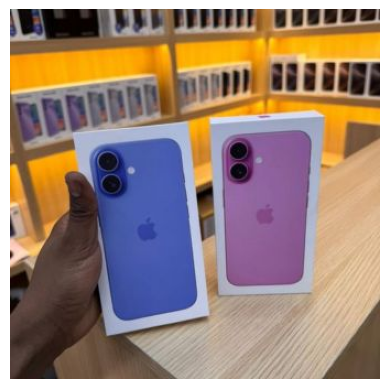

Formatted prompt: <|begin_of_text|><|start_header_id|>user<|end_header_id|>

What kind of phone do you see?<|image|><|eot_id|><|start_header_id|>assistant<|end_header_id|>


Prediction: 

Two iPhone 16s visible in store display. One in blue, one in purple.



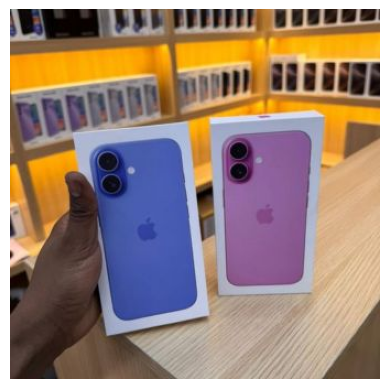

Formatted prompt: <|begin_of_text|><|start_header_id|>user<|end_header_id|>

What kind of phone do you see?<|image|><|eot_id|><|start_header_id|>assistant<|end_header_id|>


Prediction: 
Person presenting two iPhone 16 models, one blue and one pink.



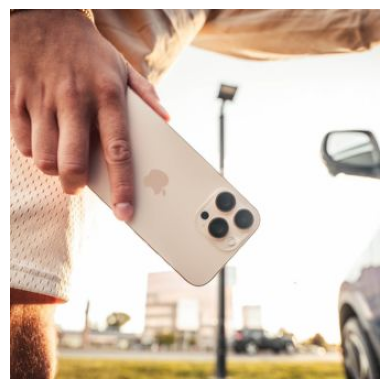

Formatted prompt: <|begin_of_text|><|start_header_id|>user<|end_header_id|>

What kind of phone do you see?<|image|><|eot_id|><|start_header_id|>assistant<|end_header_id|>


Prediction: iPhone 16 Pro Max in hand, highlighting camera design.



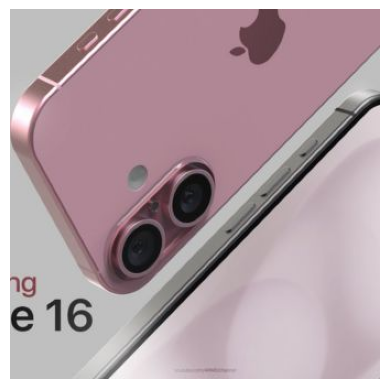

Formatted prompt: <|begin_of_text|><|start_header_id|>user<|end_header_id|>

What kind of phone do you see?<|image|><|eot_id|><|start_header_id|>assistant<|end_header_id|>


Prediction: 
Partial view of iPhone 16 Pro Max's camera module.



In [143]:
eval_results = run_model_evaluation(model, eval_dataset, num_samples=5, device='cuda', 
                                    constant_query="What kind of phone do you see?"
                                    # constant_query="Que voyez vous ici?"
                                   )

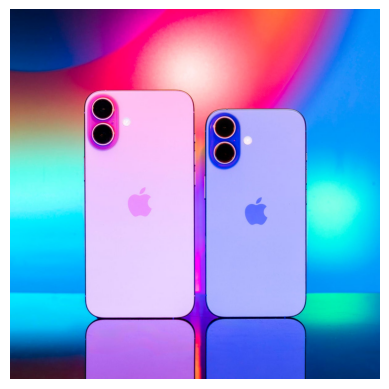

Prediction: 

Two iPhone 16s in different colors.


In [144]:
# Example usage
image_url = "iPhone 16 test/iphone-16-plus-iphone-16-4535.jpg"
result = evaluate_image(image_url, model, processor)

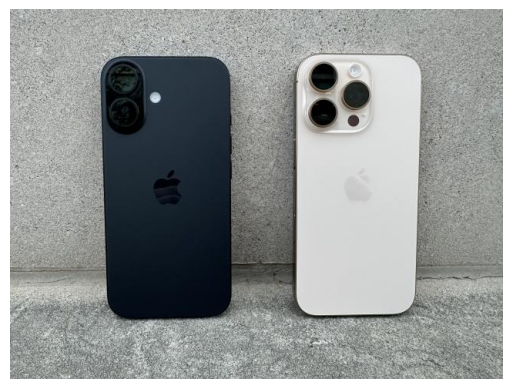

Prediction: 

Two iPhone 16 models showcasing different camera configurations.


In [145]:
image_url = "iPhone 16 test/a4706e30-7752-11ef-9e9f-7b344b78d83b.jpg"
result = evaluate_image(image_url, model, processor)

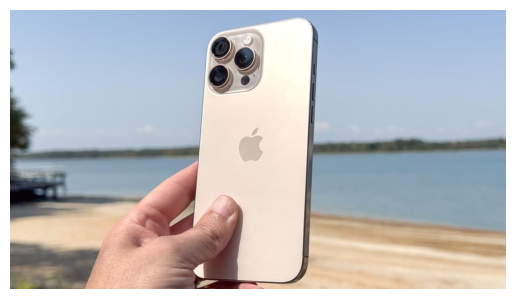

Prediction: 

iPhone 16 Pro Max in hand, showing rear design.


In [146]:
image_url = "iPhone 16 test/apple-iphone-16-pro-max-review-huge-display-insane-battery-v0-Haq1B4LsU13euFDToI48-KkqGqReD0wY-eUxfCY51hk.jpg"
result = evaluate_image(image_url, model, processor)

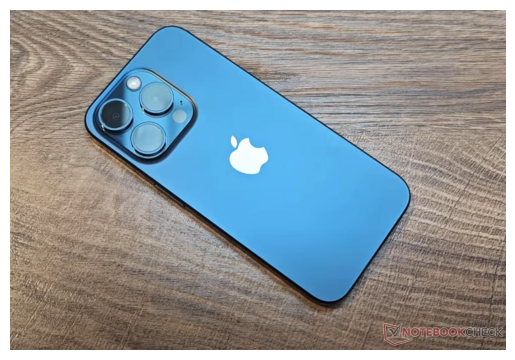

Prediction: 

Blue iPhone 16 with dual camera system visible.


In [147]:
image_url = "iPhone 16 test/iphoen_16_pro_rumors_brighter_display_pro_max.jpg"
result = evaluate_image(image_url, model, processor)

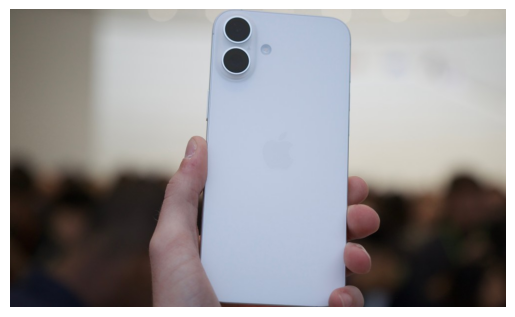

Prediction: 

White iPhone 16 with dual camera system.


In [148]:
image_url = "iPhone 16 test/iphone-16-hands-on-7.jpeg"
result = evaluate_image(image_url, model, processor)